In [31]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

### Load the dataset

In [32]:
# Constants
SEED = 42
N_SPLITS = 5

# Load dataset
train_df = pd.read_csv('/kaggle/input/shl-audio/dataset/train.csv')
TRAIN_AUDIO_DIR = '/kaggle/input/shl-audio/dataset/audios_train/'

In [33]:
train_df.head()

,filename,label
0,audio_1261.wav,1.0
1,audio_942.wav,1.5
2,audio_1110.wav,1.5
3,audio_1024.wav,1.5
4,audio_538.wav,2.0


In [34]:
train_df.shape

(444, 2)

In [35]:
print(train_df.columns)
print(train_df.head())


Index(['filename', 'label'], dtype='object')
         filename  label
0  audio_1261.wav    1.0
1   audio_942.wav    1.5
2  audio_1110.wav    1.5
3  audio_1024.wav    1.5
4   audio_538.wav    2.0


In [36]:
# Feature extraction function
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    features = []

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features.extend(np.mean(mfccs, axis=1))

    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features.extend(np.mean(chroma, axis=1))

    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    features.extend(np.mean(contrast, axis=1))

    zcr = librosa.feature.zero_crossing_rate(y)
    features.append(np.mean(zcr))

    rms = librosa.feature.rms(y=y)
    features.append(np.mean(rms))

    return features


In [37]:
# Extract features
X, y = [], []
print("Extracting features...")
for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    file_path = os.path.join(TRAIN_AUDIO_DIR, row['filename'])
    try:
        features = extract_features(file_path)
        X.append(features)
        y.append(row['label'])
    except:
        continue

X = np.array(X)
y = np.array(y)

Extracting features...


100%|██████████| 444/444 [04:40<00:00,  1.59it/s]


In [38]:
# Models
models = {
    "GradientBoosting": GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, max_depth=4, random_state=SEED),
    "XGBoost": xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1,
        reg_alpha=0.5,
        random_state=SEED,
        objective='reg:squarederror'
    )
}

# Cross-validation
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for model_name, model in models.items():
    print(f"\n🔍 Evaluating model: {model_name}")
    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        mse = mean_squared_error(y_val, y_pred)
        mae = mean_absolute_error(y_val, y_pred)
        pearson, _ = pearsonr(y_val, y_pred)

        print(f"  Fold {fold}: MSE={mse:.4f}, MAE={mae:.4f}, Pearson={pearson:.4f}")



🔍 Evaluating model: GradientBoosting
  Fold 1: MSE=0.7853, MAE=0.7242, Pearson=0.6559
  Fold 2: MSE=0.8179, MAE=0.7582, Pearson=0.5547
  Fold 3: MSE=0.6653, MAE=0.6646, Pearson=0.6889
  Fold 4: MSE=0.8852, MAE=0.7495, Pearson=0.5411
  Fold 5: MSE=0.6346, MAE=0.6709, Pearson=0.7015

🔍 Evaluating model: XGBoost
  Fold 1: MSE=0.7804, MAE=0.7296, Pearson=0.6688
  Fold 2: MSE=0.7676, MAE=0.7401, Pearson=0.5909
  Fold 3: MSE=0.7168, MAE=0.6848, Pearson=0.6607
  Fold 4: MSE=0.7276, MAE=0.6873, Pearson=0.6234
  Fold 5: MSE=0.6225, MAE=0.6604, Pearson=0.7221


In [39]:
from sklearn.model_selection import KFold

# Use the same seed and split settings as before
SEED = 42
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Get Fold 5’s indices
for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    if i == 4:  # Fold 5 (index starts from 0)
        X_fold5_train, y_fold5_train = X[train_idx], y[train_idx]
        X_fold5_val, y_fold5_val = X[val_idx], y[val_idx]
        break

# Retrain on Fold 5 training data
best_fold_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    reg_alpha=0.5,
    random_state=42,
    objective='reg:squarederror'
)
best_fold_model.fit(X_fold5_train, y_fold5_train)

# Optional: Evaluate again on Fold 5 validation data
y_val_pred = best_fold_model.predict(X_fold5_val)
mse = mean_squared_error(y_fold5_val, y_val_pred)
mae = mean_absolute_error(y_fold5_val, y_val_pred)
pearson_corr, _ = pearsonr(y_fold5_val, y_val_pred)

print(f"✅ Re-eval on Fold 5 validation:\nMSE: {mse:.4f}, MAE: {mae:.4f}, Pearson: {pearson_corr:.4f}")


✅ Re-eval on Fold 5 validation:
MSE: 0.6225, MAE: 0.6604, Pearson: 0.7221


In [40]:
# Extract features for test set (no labels)
X_test = []

print("Extracting test features...")
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    file_path = os.path.join(TEST_AUDIO_DIR, row['filename'])
    features = extract_features(file_path)
    X_test.append(features)

X_test = np.array(X_test)


Extracting test features...


100%|██████████| 195/195 [01:58<00:00,  1.65it/s]


In [41]:
# Predict on test data using the Fold 5 trained model
y_test_pred = best_fold_model.predict(X_test)

# Save predictions to CSV
predictions_df = pd.DataFrame({
    'filename': test_df['filename'],
    'label': y_test_pred
})

predictions_df.to_csv('submission.csv', index=False)
print("✅ Predictions saved to submission.csv using Fold 5 model!")


✅ Predictions saved to submission.csv using Fold 5 model!


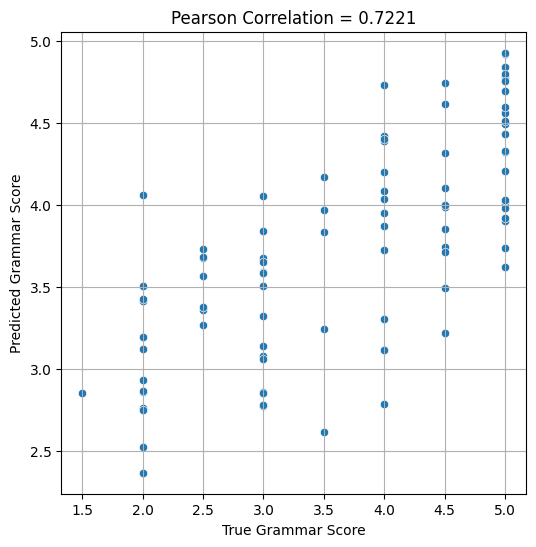

In [42]:
# Scatter plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_val, y=y_pred)
plt.xlabel("True Grammar Score")
plt.ylabel("Predicted Grammar Score")
plt.title(f"Pearson Correlation = {pearson_corr:.4f}")
plt.grid()
plt.show()

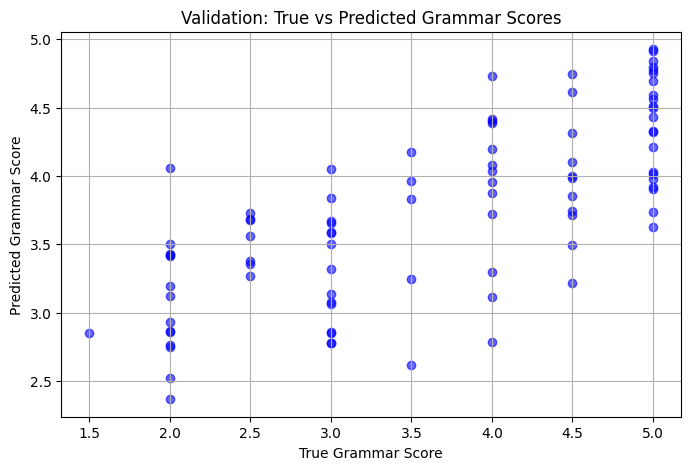

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(y_val, y_pred, alpha=0.6, color='blue')
plt.xlabel("True Grammar Score")
plt.ylabel("Predicted Grammar Score")
plt.title("Validation: True vs Predicted Grammar Scores")
plt.grid(True)
plt.show()


True vs Predicted Grammar Scores (Scatter Plot)
Purpose:
Shows how close the model’s predicted grammar scores are to the actual scores.

Good Points:

Most points follow a diagonal trend → predictions are close to real values.

The model performs well for high grammar scores (4 to 5).

Positive correlation shows the model is learning.

Weak Points:

More spread in predictions for low scores (2 to 3).

Some under- or over-predictions.



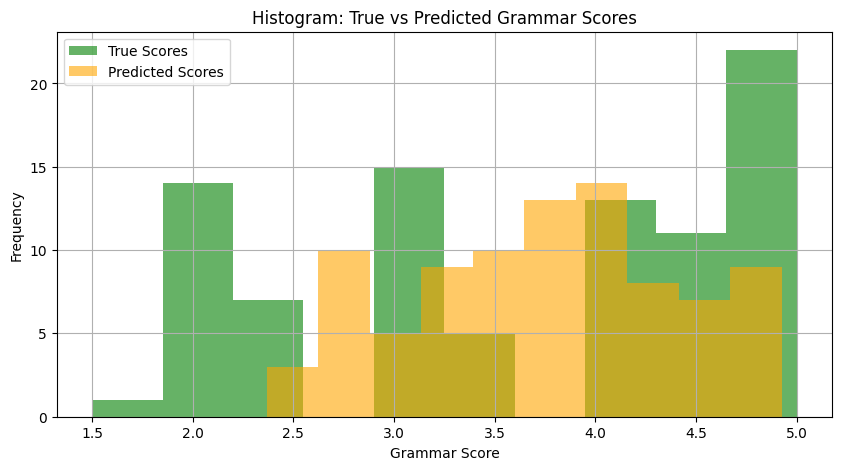

In [47]:
plt.figure(figsize=(10,5))
plt.hist(y_val, bins=10, alpha=0.6, label='True Scores', color='green')
plt.hist(y_pred, bins=10, alpha=0.6, label='Predicted Scores', color='orange')
plt.xlabel("Grammar Score")
plt.ylabel("Frequency")
plt.title("Histogram: True vs Predicted Grammar Scores")
plt.legend()
plt.grid(True)
plt.show()


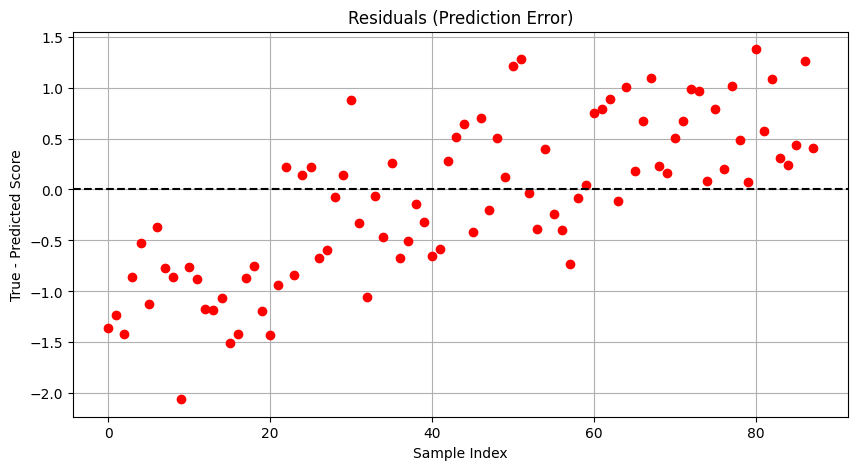

In [48]:
errors = y_val - y_pred

plt.figure(figsize=(10, 5))
plt.plot(errors, marker='o', linestyle='', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals (Prediction Error)")
plt.xlabel("Sample Index")
plt.ylabel("True - Predicted Score")
plt.grid(True)
plt.show()


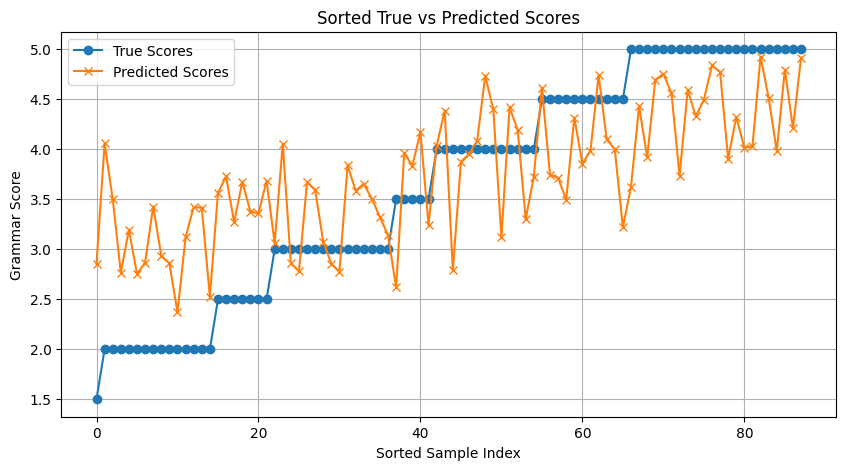

In [49]:
sorted_idx = np.argsort(y_val)

plt.figure(figsize=(10, 5))
plt.plot(np.array(y_val)[sorted_idx], label='True Scores', marker='o')
plt.plot(np.array(y_pred)[sorted_idx], label='Predicted Scores', marker='x')
plt.title("Sorted True vs Predicted Scores")
plt.xlabel("Sorted Sample Index")
plt.ylabel("Grammar Score")
plt.legend()
plt.grid(True)
plt.show()
